## Goals to complete:
- Build raw neural network
- Use Keras Resnet50

## Steps:
1. **Write python file to seperate images**
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n
2. **Visualize data**
3. **Create image generator**
4. **Load data**
5. **Create model**
6. **Fit model**
7. **Plot history**
8. **Check overfitting**
9. **Get result**

## Notes:
- (Accuracy -- Val_accuracy) and (Loss -- Val_loss): Check overfitting
- MaxPooling2D: Reduce image size

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Visualize data

(374, 500, 3)


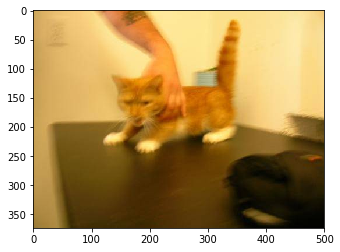

In [2]:
cat0 = cv2.imread('dataset/train/cat/cat.0.jpg')
cat0 = cv2.cvtColor(cat0, cv2.COLOR_BGR2RGB)
print(cat0.shape)

plt.imshow(cat0)

(375, 499, 3)


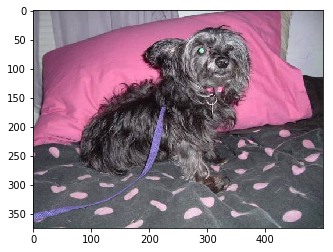

In [3]:
dog0 = cv2.imread('dataset/train/dog/dog.0.jpg')
dog0 = cv2.cvtColor(dog0, cv2.COLOR_BGR2RGB)
print(dog0.shape)

plt.imshow(dog0)

### Create ImageDataGenerator

In [4]:
image_gen = ImageDataGenerator(rotation_range=15,
                               rescale=1./255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               validation_split=0.1)

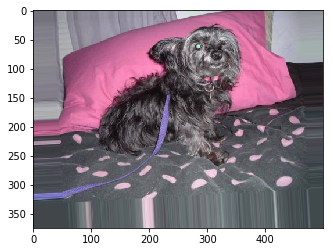

In [5]:
plt.imshow(image_gen.random_transform(dog0))

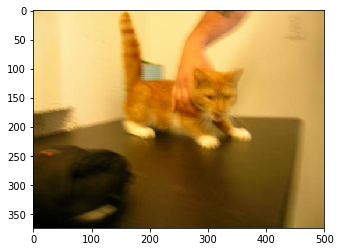

In [6]:
plt.imshow(image_gen.random_transform(cat0))

### Load data

In [7]:
directory = 'dataset/train'
batch_size = 64
image_shape = (127, 127, 3)

train_data = image_gen.flow_from_directory(directory,
                                          target_size=image_shape[:2],
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset='training')

test_data = image_gen.flow_from_directory(directory,
                                          target_size=image_shape[:2],
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset='validation')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


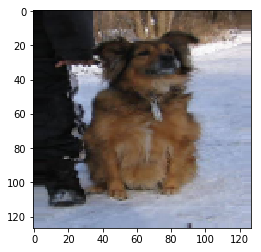

In [8]:
plt.imshow(train_data[0][0][4])

In [9]:
print(train_data.samples, test_data.samples)

22500 2500


### Create model

In [10]:
base_model = MobileNetV2(input_shape=image_shape,
                         include_top=False,
                         weights='imagenet')

/usr/local/lib/python3.5/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [11]:
base_model.trainable = False

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 127, 127, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [13]:
model = Sequential([
    base_model,
    GlobalMaxPooling2D(),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
len(model.trainable_variables)

2

### Fit model

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
earlystop = EarlyStopping(patience=10)
callbacks = [earlystop]

In [18]:
results = model.fit_generator(train_data,
                              epochs=10,
                              validation_data=test_data,
                              validation_steps=test_data.samples//batch_size,
                              steps_per_epoch=train_data.samples//batch_size,
                              callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 351 steps, validate for 39 steps
Epoch 1/10
351/351 [==============================] - 298s 850ms/step - loss: 0.5110 - categorical_accuracy: 0.8369 - val_loss: 0.4163 - val_categorical_accuracy: 0.8862
Epoch 2/10
351/351 [==============================] - 98s 281ms/step - loss: 0.3680 - categorical_accuracy: 0.8690 - val_loss: 0.2510 - val_categorical_accuracy: 0.9139
Epoch 3/10
351/351 [==============================] - 98s 280ms/step - loss: 0.3347 - categorical_accuracy: 0.8760 - val_loss: 0.2436 - val_categorical_accuracy: 0.9175
Epoch 4/10
351/351 [==============================] - 98s 279ms/step - loss: 0.3323 - categorical_accuracy: 0.8722 - val_loss: 0.3071 - val_categorical_accuracy: 0.9087
Epoch 5/10
351/351 [==============================] - 98s 279ms/step - loss: 0.3117 - categorical_accuracy: 0.8777 - val_loss: 0.5159 - val_categorical_ac

In [19]:
model.save('model2.h5')

### Plot history

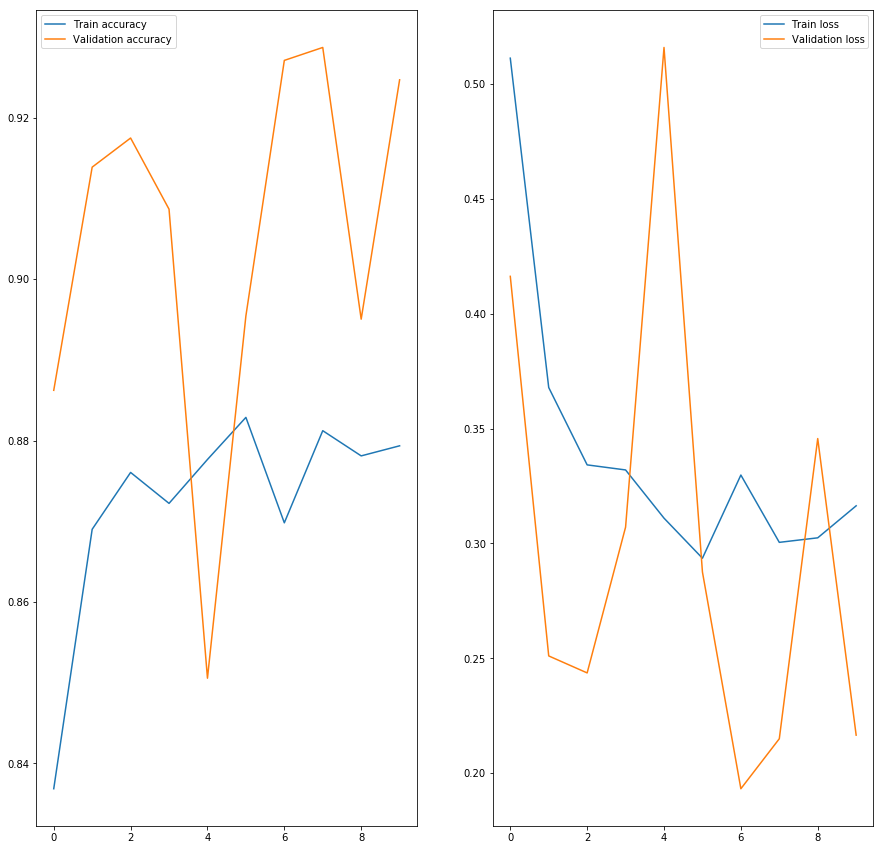

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].plot(results.history['categorical_accuracy'], label='Train accuracy')
ax[0].plot(results.history['val_categorical_accuracy'], label='Validation accuracy')
ax[0].legend(['Train accuracy', 'Validation accuracy'])

ax[1].plot(results.history['loss'], label='Train loss')
ax[1].plot(results.history['val_loss'], label='Validation loss')
ax[1].legend(['Train loss', 'Validation loss'])

plt.show()

### Get result

In [25]:
test_filenames = os.listdir('dataset/test/test')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [26]:
test_gen = ImageDataGenerator(rescale=1./255)

test_set = test_gen.flow_from_dataframe(
    test_df,
    'dataset/test/test',
    target_size=image_shape[:2],
    batch_size=batch_size,
    x_col='filename',
    y_col=None,
    class_mode=None,
    shuffle=False
)

Found 12500 validated image filenames.


In [27]:
predictions = model.predict_generator(test_set)

Instructions for updating:
Please use Model.predict, which supports generators.


In [45]:
test_df['label'] = predictions.argmax(axis=1)

In [46]:
test_df['id'] = test_df['filename'].str.split('.').str[0]
test_df = test_df.drop('filename', axis=1)

In [47]:
test_df.to_csv(path_or_buf='result2.csv', index=False)